In [38]:
!pip install dmba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from dmba import stepwise_selection
from dmba import AIC_score

In [40]:
%matplotlib inline

In [41]:
df = pd.read_csv('./cybersec_final_data.csv', sep=';', decimal=',', index_col='ID')
columns = ['ROA', 'ROE', 'IND', 'INFR', 'PEOPLE', 'PARTNERS']
df = df[columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1127 entries, 1 to 487
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ROA       1120 non-null   float64
 1   ROE       1117 non-null   float64
 2   IND       1127 non-null   int64  
 3   INFR      1127 non-null   int64  
 4   PEOPLE    1127 non-null   int64  
 5   PARTNERS  1127 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 61.6 KB


#Preprocessing

In [42]:
df.drop('IND', axis=1).corr()

,ROA,ROE,INFR,PEOPLE,PARTNERS
ROA,1.000000,0.008218,0.116992,0.078316,0.001306
ROE,0.008218,1.000000,0.520908,0.356874,0.255719
INFR,0.116992,0.520908,1.000000,0.706253,0.295150
PEOPLE,0.078316,0.356874,0.706253,1.000000,0.228645
PARTNERS,0.001306,0.255719,0.295150,0.228645,1.000000


In [43]:
df = df.drop(['ROA', 'PEOPLE'], axis=1)

In [44]:
df = pd.get_dummies(df, columns = ['IND'])
df = df.rename( columns={ 
    'IND_1':'IT&Telecom', 'IND_2':'Finance', 'IND_3':'Construction', 
    'IND_4':'Manufacture', 'IND_5':'Energy', 'IND_6':'Medicine', 'IND_7':'Others'})
df_cluster = df.drop('ROE', axis=1)

In [45]:
df['ROE'] = df['ROE'].replace(np.NaN, df['ROE'].mean())

In [46]:
df_tream = df[df['Others'] !=1].drop(['Others'], axis=1)

In [47]:
X_reg = df_tream.loc[:, ~df_tream.columns.isin(['ROE'])]
Y = df_tream['ROE']

#Regression

In [48]:
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(X_reg[variables], Y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(Y, [Y.mean()] * len(Y), model, df=1)
    return AIC_score(Y, model.predict(X_reg[variables]), model)

def get_stepwise_selection():
  _, best_variables = stepwise_selection(X_reg.columns, train_model, score_model, verbose=True)
  return best_variables

def print_model(Y, X_reg):
    predictors = get_stepwise_selection()
    lm_factor_ols = sm.OLS(Y, X_reg[predictors].assign(const=1))
    results = lm_factor_ols.fit()
    return results.summary()

print_model(Y, X_reg)

Variables: INFR, PARTNERS, IT&Telecom, Finance, Construction, Manufacture, Energy, Medicine
Start: score=5531.24, constant
Step: score=5203.77, add INFR
Step: score=5196.63, add PARTNERS
Step: score=5190.90, add Medicine
Step: score=5190.90, unchanged None


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    ROE   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     140.8
Date:                Wed, 11 Jan 2023   Prob (F-statistic):           1.84e-74
Time:                        11:55:51   Log-Likelihood:                -2590.5
No. Observations:                 881   AIC:                             5189.
Df Residuals:                     877   BIC:                             5208.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
INFR          11.4972      0.625     18.403      0.000      10.271      12.723
PARTNERS       1.3162      0.435      3.027      0.003       0.463       2.170
Medicine      -1.2713      0.458     -2.779      0.006      -2.169      -0.373
const        -36.9373      1.822    -20.278      0.000     -40.512     -33.362
==============================================================================
Omnibus:                     1458.637   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          2498795.771
Skew:                          -9.741   Prob(JB):                         0.00
Kurtosis:                     263.177   Cond. No.                         46.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#Classification

###"Отраслевой" случай
####Метки проставлены на основе принадлежности к определенному виду деятельности

In [49]:
df_class = df_tream.drop('IT&Telecom', axis=1)
df_class['class_industry'] = np.where((df_class['Finance'] == 1) | (df_class['Medicine'] == 1), '1', '0')
X_ind = df_class.loc[:, ['INFR', 'PARTNERS', 'Finance']]
Y_ind = df_class['class_industry']
X_ind.columns

Index(['INFR', 'PARTNERS', 'Finance'], dtype='object')

###"Стоимостной" случай
####Метки проставлены относительно медианного значения ROE

In [50]:
df_class = df_tream.drop('IT&Telecom', axis=1)
df_class['class_roe'] = np.where(df_class['ROE'] > df_class['ROE'].median(), '1', '0')
X_roe = df_class.loc[:, ~df_class.columns.isin(['ROE, class_roe'])]
Y_roe = df_class['class_roe']
X_roe.columns

Index(['ROE', 'INFR', 'PARTNERS', 'Finance', 'Construction', 'Manufacture',
       'Energy', 'Medicine', 'class_roe'],
      dtype='object')

In [51]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = X_ind
y = Y_ind

le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
            train_test_split(X, y, 
                             test_size=0.2, 
                             random_state=1,
                             stratify=y)

In [52]:
from sklearn.preprocessing import StandardScaler  
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

clf1 = LogisticRegression(penalty='l2', 
                          C=0.001,
                          solver='lbfgs',
                          random_state=1)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])

pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic regression', 'Decision tree', 'KNN']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.3f (+/- %0.3f) [%s]"
          % (scores.mean(), scores.std(), label))

tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=3,
                              random_state=1)

bag = RandomForestClassifier(
                        n_estimators=1000, 
                        max_samples=1.0, 
                        max_features=1.0, 
                        bootstrap=True, 
                        n_jobs=1, 
                        random_state=1)

grad = GradientBoostingClassifier(
                         n_estimators=1000, 
                         learning_rate=0.1,
                         random_state=1)

10-fold cross validation:

ROC AUC: 0.856 (+/- 0.063) [Logistic regression]
ROC AUC: 0.850 (+/- 0.048) [Decision tree]
ROC AUC: 0.800 (+/- 0.106) [KNN]


In [53]:
from sklearn.metrics import accuracy_score

tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('Decision tree train/test accuracies %.3f/%.3f'
      % (tree_train, tree_test))

bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)

bag_train = accuracy_score(y_train, y_train_pred) 
bag_test = accuracy_score(y_test, y_test_pred) 
print('RandomForest train/test accuracies %.3f/%.3f'
      % (bag_train, bag_test))

grad = grad.fit(X_train, y_train)
y_train_pred = grad.predict(X_train)
y_test_pred = grad.predict(X_test)

grad_train = accuracy_score(y_train, y_train_pred) 
grad_test = accuracy_score(y_test, y_test_pred) 
print('GradientBoost train/test accuracies %.3f/%.3f'
      % (grad_train, grad_test))

Decision tree train/test accuracies 0.874/0.881
RandomForest train/test accuracies 0.874/0.881
GradientBoost train/test accuracies 0.874/0.864


###ROC CURVE

ROC AUC: 0.850 (+/- 0.048) [Decision Tree]
ROC AUC: 0.800 (+/- 0.106) [K Nearest Neighbors]
ROC AUC: 0.850 (+/- 0.054) [Random Forest]
ROC AUC: 0.849 (+/- 0.058) [Boosting]


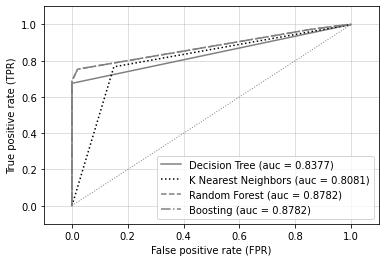

In [54]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import cross_val_score

all_clf = [clf2, pipe3, bag, grad]
clf_labels = ['Decision Tree', 'K Nearest Neighbors', 'Random Forest', 'Boosting']
colors = ['gray', 'black', 'grey', 'grey']
linestyles = ['-', ':', '--', '-.']

for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.3f (+/- %0.3f) [%s]"
          % (scores.mean(), scores.std(), label))

for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(X_train,
                     y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.4f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle=':',
         color='gray',
         linewidth=1)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')

plt.savefig('./image', dpi=900)
plt.show()